In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from KCNODE import get_KCNODE_FT_model

# Building the kinetic-constrained neural ODE model and import trained parameters

In [2]:
PATH = r'trained_models\KCNODE_FT.pt'
model = get_KCNODE_FT_model()
model.load_state_dict(torch.load(PATH))

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


<All keys matched successfully>

# Generating inputs for KCNODE

Unit for molar flow: $mmol/min$

Unit for tau (catalyst volume): $dm^3$

In [3]:
amount_HC = 15
amount_alcohols = 7
compounds = ['N2', 'CO2', 'CO', 'H2', 'H2O', 
             *[f'C{i}an' for i in range(1, amount_HC + 1)], 
             *[f'C{i}en' for i in range(2, amount_HC + 1)],
             *[f'C{i}OH' for i in range(1, amount_alcohols + 1)],
            ]

reaction_condition = ['P', 'temp', 'tos']
inputs_name = reaction_condition + compounds
inputs_dict = {i:[0] for i in inputs_name}

# set condition, 15 bar, 250 °C, CO2:H2:N2 = 1:3:1, time-on-stream 200 h

pressure = 15
temperature = 250
time_on_stream = 200

inputs_dict['P'] = [pressure / 20]
inputs_dict['tos'] = [time_on_stream / 250]
inputs_dict['temp'] = [10000/8.31*(1/(temperature+273.15) - 1/(280+273.15))]

inputs_dict['CO2'] = [1]
inputs_dict['H2'] = [3]
inputs_dict['N2'] = [1]

inputs_df = pd.DataFrame(inputs_dict)

inputs = torch.tensor(inputs_df.values, requires_grad=True).float()
tau = torch.tensor(np.append([0], np.linspace(1e-6, 0.01, 100)), requires_grad=True).float()

# Plot results

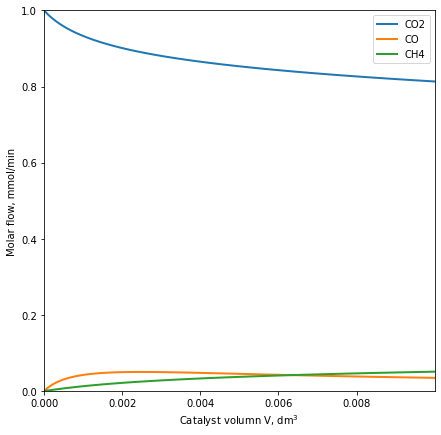

In [4]:
res = model(inputs, tau)
CO2 = res[:, 0, 4]
CO = res[:, 0, 5]
CH4 = res[:, 0, 8]


plt.figure(figsize=(7, 7))

plt.plot(tau.detach().numpy(), CO2.detach().numpy(), '-', lw=2, alpha=1, label='CO2')
plt.plot(tau.detach().numpy(), CO.detach().numpy(), '-', lw=2, alpha=1, label='CO')
plt.plot(tau.detach().numpy(), CH4.detach().numpy(), '-', lw=2, alpha=1, label='CH4')

plt.xlabel('Catalyst volumn V, dm$^3$')
plt.ylabel('Molar flow, mmol/min')

plt.xlim(0, tau.detach().numpy().max())
plt.ylim(0, 1)

plt.legend()

plt.show()